In [0]:
colab = True
if colab:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1nnsLbtFQ944iU-bw06I34kuQS7n-VBdL', dest_path='./data.zip')

    from zipfile import ZipFile
    with ZipFile('data.zip', 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall()

In [0]:
# Unzip mnist data
!gzip -d ./data/t10k-images-idx3-ubyte.gz ./data/t10k-labels-idx1-ubyte.gz ./data/train-labels-idx1-ubyte.gz ./data/train-images-idx3-ubyte.gz

In [0]:
# Install idx2numpy for reading MNIST
!pip install idx2numpy

  Created wheel for idx2numpy: filename=idx2numpy-1.2.2-cp36-none-any.whl size=8032 sha256=da2b80611b3d74494f3ac677498848a688493262221488ae6b40d90b1cd01f5b
  Stored in directory: /root/.cache/pip/wheels/7a/b5/69/3e0757b3086607e95db70661798fdf98a77a0bb79c54e1f320
Successfully built idx2numpy


<h1 align='center'>Projet Deep Learning II</h1>

<h4 align='center'>Authors : Kevin XU & Qin WANG</h4>

## Table of Contents
1. [Introduction](#intro)
2. [Données](#donnees)
3. [Fonctions élémentaires](#fctelementaire)
    + [Construction d'un RBM et test sur Binary AlphaDigits](#constructionRBM)
    + [Construction d’un DBN et test sur Binary AlphaDigits](#constructionDBN)
    + [Construction d’un DNN et test sur MNIST](#constructionDNN)
4. [Travail préliminaire (Binary AlphaDigit)](#travailprelim)
5. [Etude à réaliser (MNIST)](#mnist)

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

import scipy.io
import scipy
from scipy.special import softmax
import idx2numpy


# <a id='intro'>1. Introduction</a>

L’objectif du projet est de réaliser un réseau de neurones profond pré-entraîné ou non pour la classification de chiffres manuscrits. On va comparer les performances, en terme de taux de bonnes classifications, d’un réseau pré-entrainé et d’un réseau initialisé aléatoirement, en fonction du nombre de données d’apprentissage, du nombre de couches du réseau et enfin du nombre de neurones par couches.


# <a id='donnees'>2. Données</a>

**To download :**
+ http://yann.lecun.com/exdb/mnist/ (les 4 fichiers)
+ https://cs.nyu.edu/~roweis/data.html (Binary Alphadigits)

In [0]:
path_to_data = './data/'

In [0]:
# Function for Binary Alphadigits dataset
alphadigs = scipy.io.loadmat(path_to_data + 'binaryalphadigs.mat')

def lire_alpha_digit(index_carac):
    """ 
    Get alpha digit data for given character.
    
    Parameters
    ----------
    index_carac : list 
        The characters that we want to learn.

    Returns
    -------
    data : ndarray
        Matrix containing the data with rows corresponding to samples and columns to pixels.
    """
    nb_pixel = alphadigs['dat'][0,0].shape[0] * alphadigs['dat'][0,0].shape[1]
    data = np.empty(shape=(1, nb_pixel))

    for i in index_carac:
        data = np.append(data, np.array([img.flatten() for img in alphadigs['dat'][i,:]]), axis=0)
    return data[1:,:]

alphadigs_data = lire_alpha_digit([10])
alphadigs_data.shape

(39, 320)

In [0]:
# Function for MNIST dataset
def to_black_white(images):
    images[images < 128] = 0
    images[images >= 128] = 1
    return images

def lire_MNIST():
    """ 
    Get alpha digit data for given character.
    
    Parameters
    ----------

    Returns
    -------
    data : ndarray
        Matrix containing the data with rows corresponding to samples and columns to pixels.
    """
    train_image_file = 'data/train-images-idx3-ubyte'
    train_label_file = 'data/train-labels-idx1-ubyte'
    test_image_file = 'data/t10k-images-idx3-ubyte'
    test_label_file = 'data/t10k-labels-idx1-ubyte'

    train_image = idx2numpy.convert_from_file(train_image_file)
    train_image = to_black_white(np.array([img.flatten() for img in train_image]))

    test_image = idx2numpy.convert_from_file(test_image_file)
    test_image = to_black_white(np.array([img.flatten() for img in test_image]))

    train_label = idx2numpy.convert_from_file(train_label_file)
    test_label = idx2numpy.convert_from_file(test_label_file)

    return train_image, train_label, test_image, test_label

train_image, train_label, test_image, test_label = lire_MNIST()
nb_labels = np.unique(train_label).shape[0]

(60000, 784)
(60000,)
(10000, 784)
(10000,)


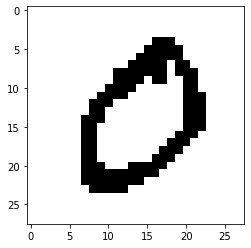

In [0]:
print(train_image.shape)
print(train_label.shape)
print(test_image.shape)
print(test_label.shape)
plt.imshow(np.reshape(train_image[1], newshape=(28,28)), cmap=plt.cm.binary)


# <a id='fctelementaire'>3. Fonctions élémentaires</a>


## <a id='constructionRBM'>3.1 Construction d'un RBM et test sur Binary AlphaDigits</a>

In [0]:
def sigmoid(x):
    """ 
    Sigmoid function.
    
    Parameters
    ----------
    x : float 
    
    Returns
    -------
    result : float
    """
    return 1 / (1 + np.exp(-x))
    
def init_RBM(p, q):
    """ 
    Create a RBM structure with weights and biases initialized.
    
    Parameters
    ----------
    p : int
        Number of visible units.
    
    q : int
        Number of hidden units.
        
    Returns
    -------
    RBM : dict
    """
    RBM = {
        "W" : np.random.randn(p, q) * 0.1,
        "a" : np.zeros(shape=(1, p)),
        "b" : np.zeros(shape=(1, q)),
        "p" : p,
        "q" : q
    }
    return RBM

def entree_sortie_RBM(RBM, input_data):
    """ 
    Compute the values of the hidden layer for given input data by the RBM.
    
    Parameters
    ----------
    RBM : dict
        A RBM structure.
    
    input_data : ndarray
        
    Returns
    -------
    result : ndarray
    """
    return sigmoid(RBM['b'] + input_data.dot(RBM['W']))

def sortie_entree_RBM(RBM, output_data):
    """ 
    Compute the values of the visible layer for given output data by the RBM.
    
    Parameters
    ----------
    RBM : dict
        A RBM structure.
    
    output_data : ndarray
        
    Returns
    -------
    result : ndarray
    """
    return sigmoid(RBM['a'] + output_data.dot(RBM['W'].T))

def train_RBM(RBM, input_data, nb_iter=100, lr=0.1, batch_size=32, verbose=True):
    """ 
    Train a RBM by Contrastive-Divergence (CD-1) algorithm.
    
    Parameters
    ----------
    RBM : dict
        A RBM structure.
    
    input_data : ndarray
        Input data.
        
    nb_iter : int
        Number of iterations.
        
    lr : float
        Learning rate.
        
    batch_size : int
        The batch size.
        
    verbose : bool
        Enable verbose output.
        
    Returns
    -------
    RBM : dict
        A RBM structure.
    """
    n = input_data.shape[0]
    p = RBM['p']
    q = RBM['q']
    for i in range(nb_iter):
        np.random.shuffle(input_data) 
        for batch in range(batch_size):
            x = input_data[np.minimum(np.arange(batch * batch_size, (batch + 1) * batch_size), n-1),:]
            v_0 = x
            h_0 = (np.random.uniform(0, 1, size=(x.shape[0], q)) < entree_sortie_RBM(RBM, x)).astype(int)
            v_1 = (np.random.uniform(0, 1, size=(x.shape[0], p)) < sortie_entree_RBM(RBM, h_0)).astype(int)
            
            da = np.sum(v_0 - v_1, axis=0)
            db = np.sum(entree_sortie_RBM(RBM, x) - entree_sortie_RBM(RBM, v_1), axis=0)
            dW = v_0.T.dot(entree_sortie_RBM(RBM, x)) - v_1.T.dot(entree_sortie_RBM(RBM, v_1))

            RBM['W'] += lr * dW / batch_size      
            RBM['a'] += lr * da / batch_size
            RBM['b'] += lr * db / batch_size
            
        if verbose:
            # erreur quadratique
            sortie = entree_sortie_RBM(RBM, input_data)
            new_entree = sortie_entree_RBM(RBM, sortie)
            erreur_reconstruction = np.sum((input_data - new_entree)**2/n)
            print("iteration %d \t : \t erreur reconstruction %.2f" % (i, erreur_reconstruction))
    return RBM

def generer_image_RBM(RBM, image_shape, nb_images=3, nb_iter_gibbs=100, plot=True):
    """ 
    Generate samples following a RBM by Gibbs sampling algorithm.
    
    Parameters
    ----------
    RBM : dict
        A RBM structure.

    image_shape : tuple
      Shape of the images
    
    nb_images : int
        Number of images to generate.
        
    nb_iter_gibbs : int
        Number of iterations in Gibbs sampling.
    
    plot : bool
        Plot the images.
        
    Returns
    -------
    images : list of arrays
        Generated samples.
    """
    p = RBM['p']
    q = RBM['q']
    images = []
    
    if plot:
        plt.figure(figsize=(20, 20))
    for i in range(nb_images):
        x = (np.random.uniform(0, 1, size=(1, p)) < 0.5).astype(int)
        for j in range(nb_iter_gibbs):
            h = (np.random.uniform(0, 1, size=(1, q)) < entree_sortie_RBM(RBM, x)).astype(int)
            x = (np.random.uniform(0, 1, size=(1, p)) < sortie_entree_RBM(RBM, h)).astype(int)
        images.append(x)

        # Plot image 
        if plot:
            x = np.reshape(x, newshape=image_shape)
            plt.subplot(1, nb_images, i+1)
            plt.axis('off')
            plt.imshow(x, cmap='gray')
    
    return images

def principal_RBM_alpha(q, index_carac, nb_images, nb_iter=100, lr=0.1, batch_size=32, nb_iter_gibbs=100, verbose=1, plot=True):
    """ 
    Learn characters of Binary AlphaDigits with a RBM.
    
    Parameters
    ----------
    q : int
        Number of hidden units.
    
    index_carac : list
        Index of characters to learn.
      
    nb_images : int
        Number of images to generate.
    
    nb_iter : int
        Number of iterations in the Gradient Descent.
        
    lr : float
        Learning rate.
        
    batch_size : int
        The batch size.

    nb_iter_gibbs : int
        Number of iterations in Gibbs sampling.
        
    verbose : bool
        Enable verbose output.
    
    plot : bool
        Plot the images.
        
    Returns
    -------
    RBM : dict
        A RBM structure.
    """
    data = lire_alpha_digit(index_carac)
    p = data.shape[1]
    image_shape = (20,16)
    RBM = init_RBM(p, q)
    RBM_trained = train_RBM(RBM, data, nb_iter, lr=lr, batch_size=batch_size, verbose=verbose)
    generer_image_RBM(RBM_trained, image_shape, nb_images, nb_iter_gibbs, plot=plot)
    return RBM_trained


## <a id='constructionDBN'>3.2 Construction d'un DBN et test sur Binary AlphaDigits</a>

In [0]:
def init_DBN(p, q=32, n_layers=2):
    """ 
    Create a DBN structure with weights and biases initialized.
    
    Parameters
    ----------
    p : int
        Number of units of visible layer.
    
    q : int
        Number of units of hidden layers.
    
    n_layers : int
        Number of layers.
        
    Returns
    -------
    DBN : list of dicts
    """
    DBN = [init_RBM(p, q)]
    
    for i in range(n_layers):
        DBN.append(init_RBM(q, q))
    return DBN
    
def train_DBN(DBN, input_data, nb_iter=100, lr=0.1, batch_size=32, verbose=True):
    """ 
    Train a DBN in a greedy layer-wise fashion.
    
    Parameters
    ----------
    DBN : list of dicts
        A DBN structure.
    
    input_data : ndarray
        Input data.
        
    nb_iter : int
        Number of iterations in the Gradient Descent.
        
    lr : float
        Learning rate.
        
    batch_size : int
        The batch size.
        
    verbose : bool
        Enable verbose output.
        
    Returns
    -------
    DBN : list of dicts
        A DBN structure.
    """
    DBN[0] = train_RBM(DBN[0], input_data, nb_iter, lr=lr, batch_size=batch_size, verbose=verbose)
    proba = entree_sortie_RBM(DBN[0], input_data)
    new_input_data = (np.random.uniform(0, 1, size=(input_data.shape[0], proba.shape[1])) < proba).astype(int)
    
    for k in range(1, len(DBN)):
        DBN[k] = train_RBM(DBN[k], new_input_data, nb_iter, lr=lr, batch_size=batch_size, verbose=verbose)
        proba = entree_sortie_RBM(DBN[k], new_input_data)
        new_input_data = (np.random.uniform(0, 1, size=(new_input_data.shape[0], proba.shape[1])) < proba).astype(int)

    return DBN

def generer_image_DBN(DBN, image_shape, nb_images=3, nb_iter_gibbs=100, plot=True):
    """ 
    Generate samples following a DBN.
    
    Parameters
    ----------
    DBN : list of dicts
        A DBN structure.
    
    image_shape : tuple
      Shape of the images
    
    nb_images : int
        Number of images to generate.
        
    nb_iter_gibbs : int
        Number of iterations in Gibbs sampling.
    
    plot : bool
        Plot the images.
        
    Returns
    -------

    """
    l = len(DBN)
    p = DBN[0]['p']
    q = DBN[0]['q']
    images = []

    if plot:
        plt.figure(figsize=(20, 20))
    for i in range(nb_images):
        x = (np.random.uniform(0, 1, size=(1, p)) < 0.5).astype(int)
        for j in range(nb_iter_gibbs):
            for k in range(l):
                h = (np.random.uniform(0, 1, size=(1, DBN[k]["q"])) < entree_sortie_RBM(DBN[k], x)).astype(int)
                x = h
            for k in range(l):
                x = (np.random.uniform(0, 1, size=(1, DBN[l-1-k]["p"])) < sortie_entree_RBM(DBN[l-1-k], h)).astype(int)
                h = x
        images.append(x)
    
        # Plot image 
        if plot:
            x = np.reshape(x, newshape=image_shape)
            plt.subplot(1, nb_images, i+1)
            plt.imshow(x, cmap='gray')

    return images

def principal_DBN_alpha(q, n_layers, index_carac, nb_images, nb_iter=100, lr=0.1, batch_size=32, nb_iter_gibbs=100, verbose=True, plot=True):
    """ 
    Learn characters of Binary AlphaDigits Binary  with a DBN.
    
    Parameters
    ----------
    q : int
        Number of hidden units.
    
    n_layers : int
        Number of layers.
        
    index_carac : list
        Index of characters to learn.
      
    nb_images : int
        Number of images to generate.
    
    nb_iter : int
        Number of iterations in the Gradient Descent.
        
    lr : float
        Learning rate.
        
    batch_size : int
        The batch size.

    nb_iter_gibbs : int
        Number of iterations in Gibbs sampling.
        
    verbose : bool
        Enable verbose output.
    
    plot : bool
        Plot the images.
        
    Returns
    -------
    DBN : dict
        A DBN structure.
    """
    data = lire_alpha_digit(index_carac)
    p = data.shape[1]
    image_shape = (20,16)
    
    DBN = init_DBN(p, q, n_layers=n_layers)
    DBN_trained = train_DBN(DBN, data, nb_iter=nb_iter, lr=lr, batch_size=batch_size, verbose=verbose)
    images = generer_image_DBN(DBN_trained, image_shape=image_shape, nb_images=nb_images, nb_iter_gibbs=nb_iter_gibbs, plot=plot)
    return DBN_trained


## <a id='constructionDNN'>3.3 Construction d'un DNN et test sur MNIST</a>

In [0]:
def calcul_softmax(RBM, input_data):
    """ 
    Compute the probabilities from the output units with the softmax function.
    
    Parameters
    ----------
    RBM : dict
        A RBM structure.
    
    input_data : ndarray
        
    Returns
    -------
    probs : ndarray
        Output probability vector.
    """
    return softmax(RBM['b'] + input_data.dot(RBM['W']), axis=1)

def entree_sortie_reseau(DNN, input_data):
    """ 
    Compute the forward pass for given input data.

    Parameters
    ----------
    DNN : dict
        A DNN structure.
    
    input_data : ndarray
        
    Returns
    -------
    result : dict
    """
    result = dict()
    result[0] = input_data
    for i in range(0, len(DNN)-1):
        result[i+1] = entree_sortie_RBM(DNN[i], result[i])
    result[i+2] = calcul_softmax(DNN[i+1], result[i+1])
    return result
    
def accuracy(output, labels):
    """
    Computes classification accuracy.

    Parameters
    ----------
    y_pred : ndarray
        Predicted probabilities.

    y_true : ndarray
        Target probabilities.
    
    Returns
    -------
    result : float
    """
    correct = (output.argmax(axis=1) == labels.argmax(axis=1)).sum()
    return correct / len(labels)
    
def to_one_hot(y):
    """ 
    One-hot encode a vector.

    Parameters
    ----------
    y : ndarray
        Labels vector

    Returns
    -------
    ohe : ndarray
        One-hot encoding of y.
    """
    ohe = np.zeros((y.size, nb_labels))
    ohe[np.arange(y.size),y] = 1
    return ohe

def cross_entropy(y_pred, y_true):
    """ 
    One-hot encode a vector.

    Parameters
    ----------
    y_pred : ndarray
        Predicted probabilities.

    y_true : ndarray
        Target probabilities.
    
    Returns
    -------
    loss : float
    """
    loss = - np.mean(np.log(y_pred) * y_true)
    return loss
    
def retropropagation(DNN, input_data, labels, nb_iter=100, lr=0.1, batch_size=32, verbose=True):
    """ 
    Perform retropropagation to estimate the weights/biaises of the network from labeled data.
    
    Parameters
    ----------
    DNN : dict
        A DNN structure.

    nb_iter : int
        Number of iterations in the Gradient Descent.
        
    lr : float
        Learning rate.
        
    batch_size : int
        The batch size.

    input_data : ndarray

    labels : ndarray
        The labels of the input data.

    verbose : bool
        Enable verbose output.
        
    Returns
    -------
    DNN : dict
        A DNN structure.
    """
    # Add a softmax layer
    DNN.append(init_RBM(DNN[0]['q'], nb_labels))

    n_layers = len(DNN)
    n = input_data.shape[0]
    for i in range(nb_iter):
        total_loss = 0
        total_accuracy = 0

        for batch in range(0, batch_size):
            x_batch = input_data[np.minimum(np.arange(batch * batch_size, (batch+1) * batch_size), n-1)]
            y_batch = labels[np.minimum(np.arange(batch * batch_size, (batch+1) * batch_size), n-1)]
            y_batch_ohe = to_one_hot(y_batch)

            # Forward
            pred = entree_sortie_reseau(DNN, x_batch)
            total_loss += cross_entropy(pred[n_layers], y_batch_ohe)
            total_accuracy += accuracy(pred[n_layers], y_batch_ohe)

            for l in range(n_layers):
                # Backward
                if l == 0:
                    delta = pred[n_layers] - y_batch_ohe
                else:
                    delta = dA * (pred[n_layers-l] * (1 - pred[n_layers-l]))
                dW = 1/batch_size * pred[n_layers-l-1].T.dot(delta)
                db = 1/batch_size * np.sum(delta, axis=0)
                dA = delta.dot(DNN[n_layers-l-1]['W'].T)
                
                # Update weights
                DNN[n_layers-l-1]['W'] -= lr * dW
                DNN[n_layers-l-1]['b'] -= lr * db

        if verbose:
            print("iteration %d \t : \t loss %.5f - accuracy %.5f" % (i, total_loss/batch_size, total_accuracy/batch_size))

    return DNN

def test_DNN(DNN_trained, test_images, test_labels):
    """ 
    Test the performances of a trained network.

    Parameters
    ----------
    DNN_trained : dict
        A DNN structure.

    test_images : ndarray
      
    test_labels : ndarray

    Returns
    -------
    error_rate : float
    """
    y_ohe = to_one_hot(test_labels)
    pred = entree_sortie_reseau(DNN_trained, test_images)
    return 1 - accuracy(pred[len(pred)-1], y_ohe)


# <a id='travailprelim'>4. Travail préliminaire (Binary AlphaDigit)</a>

iteration 0 	 : 	 erreur reconstruction 92.93
iteration 1 	 : 	 erreur reconstruction 121.85
iteration 2 	 : 	 erreur reconstruction 101.82
iteration 3 	 : 	 erreur reconstruction 90.60
iteration 4 	 : 	 erreur reconstruction 112.39
iteration 5 	 : 	 erreur reconstruction 79.80
iteration 6 	 : 	 erreur reconstruction 109.72
iteration 7 	 : 	 erreur reconstruction 83.89
iteration 8 	 : 	 erreur reconstruction 79.87
iteration 9 	 : 	 erreur reconstruction 81.66
iteration 10 	 : 	 erreur reconstruction 72.41
iteration 11 	 : 	 erreur reconstruction 73.62
iteration 12 	 : 	 erreur reconstruction 95.78
iteration 13 	 : 	 erreur reconstruction 87.13
iteration 14 	 : 	 erreur reconstruction 81.01
iteration 15 	 : 	 erreur reconstruction 80.87
iteration 16 	 : 	 erreur reconstruction 69.40
iteration 17 	 : 	 erreur reconstruction 69.02
iteration 18 	 : 	 erreur reconstruction 70.87
iteration 19 	 : 	 erreur reconstruction 71.81
iteration 20 	 : 	 erreur reconstruction 73.98
iteration 21 	 : 	 

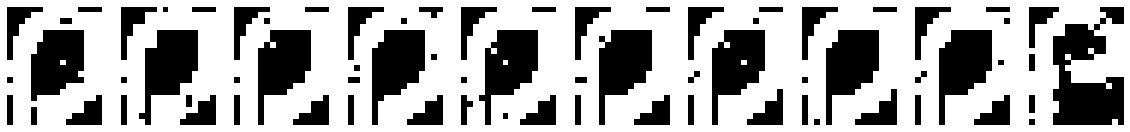

In [0]:
# Parameters
q = 256
index_carac = [2, 17, 25]
nb_images = 10
nb_iter = 100
lr = 0.1
batch_size = 64
nb_iter_gibbs = 50
verbose = True
plot = True

RBM_trained = principal_RBM_alpha(q, index_carac, nb_images, nb_iter, 
                                  lr, batch_size, nb_iter_gibbs, 
                                  verbose, plot)
# images = generer_image_RBM(RBM_trained, image_shape, nb_images, nb_iter_gibbs)

iteration 0 	 : 	 erreur reconstruction 100.75
iteration 1 	 : 	 erreur reconstruction 89.12
iteration 2 	 : 	 erreur reconstruction 122.64
iteration 3 	 : 	 erreur reconstruction 120.80
iteration 4 	 : 	 erreur reconstruction 87.18
iteration 5 	 : 	 erreur reconstruction 94.44
iteration 6 	 : 	 erreur reconstruction 95.19
iteration 7 	 : 	 erreur reconstruction 85.61
iteration 8 	 : 	 erreur reconstruction 71.81
iteration 9 	 : 	 erreur reconstruction 84.97
iteration 10 	 : 	 erreur reconstruction 110.90
iteration 11 	 : 	 erreur reconstruction 81.10
iteration 12 	 : 	 erreur reconstruction 69.19
iteration 13 	 : 	 erreur reconstruction 67.72
iteration 14 	 : 	 erreur reconstruction 68.81
iteration 15 	 : 	 erreur reconstruction 66.02
iteration 16 	 : 	 erreur reconstruction 76.51
iteration 17 	 : 	 erreur reconstruction 72.80
iteration 18 	 : 	 erreur reconstruction 77.32
iteration 19 	 : 	 erreur reconstruction 66.29
iteration 20 	 : 	 erreur reconstruction 80.06
iteration 21 	 : 	 

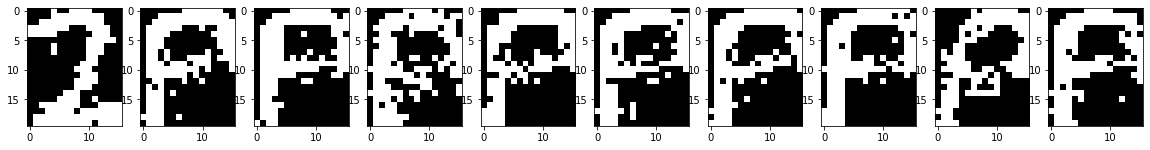

In [0]:
# Parameters
q = 64
n_layers = 3
index_carac = [2, 17, 25]
nb_images = 10
nb_iter = 100
lr = 0.1
batch_size = 64
nb_iter_gibbs = 100
verbose = True
plot = True

DBN_trained = principal_DBN_alpha(q, n_layers, index_carac, nb_images, nb_iter, lr, batch_size, nb_iter_gibbs, verbose, plot=plot)
# images = generer_image_DBN(DBN_trained, image_shape, nb_images, nb_iter_gibbs, plot=plot)


# <a id='mnist'>5. Etude à réaliser (MNIST)</a>

## 5.1 Programme

In [0]:
def principal_mnist(n_samples, DNN_trained, pre_train, nb_iter=200, nb_iter_RBM=100, lr=0.1, batch_size=32, verbose=True):
    """ 
    Learn characters of MNIST.
    
    Parameters
    ----------
    n_samples : int
        Number of training data.

    DNN_trained : dict
        A DBN structure.

    pre_train : bool
        Pre-training of the network.
    
    nb_iter : int
        Number of iterations in the Gradient Descent of backpropagation.

    nb_iter_RBM : int
        Number of iterations in the Gradient Descent of RBM.
        
    lr : float
        Learning rate.
        
    batch_size : int
        The batch size.
        
    verbose : bool
        Enable verbose output.
    
    Returns
    -------
    DNN : dict
        A DBN structure.
    """
    mask = random.sample(list(np.arange(train_image.shape[0])), n_samples)
    input_data = train_image[mask]
    labels = train_label[mask]
    
    if pre_train:
        DNN_trained = train_DBN(DNN_trained, input_data.copy(), nb_iter=nb_iter_RBM, lr=lr, batch_size=batch_size, verbose=False)
        
    # Training
    DNN_trained = retropropagation(DNN_trained, input_data, labels, nb_iter=nb_iter, lr=lr, batch_size=batch_size, verbose=verbose)

    return DNN_trained

In [0]:
n_samples = 60000
p = train_image.shape[1]
q = 256
n_layers = 1
pre_train = True
nb_iter = 50
nb_iter_RBM = 50
lr = 0.1
batch_size = 64
verbose = True

DNN_trained = init_DBN(p, q, n_layers)
DNN_trained = principal_mnist(n_samples, DNN_trained, pre_train, nb_iter=nb_iter, nb_iter_RBM=nb_iter_RBM, lr=lr, batch_size=batch_size, verbose=verbose)

print("Error rate on test set : %.5f" % (test_DNN(DNN_trained, test_image, test_label)))

iteration 0 	 : 	 loss 0.11637 - accuracy 0.68726
iteration 1 	 : 	 loss 0.05809 - accuracy 0.86548
iteration 2 	 : 	 loss 0.04628 - accuracy 0.88672
iteration 3 	 : 	 loss 0.04065 - accuracy 0.89404
iteration 4 	 : 	 loss 0.03714 - accuracy 0.90112
iteration 5 	 : 	 loss 0.03464 - accuracy 0.90625
iteration 6 	 : 	 loss 0.03270 - accuracy 0.91040
iteration 7 	 : 	 loss 0.03113 - accuracy 0.91357
iteration 8 	 : 	 loss 0.02979 - accuracy 0.91553
iteration 9 	 : 	 loss 0.02864 - accuracy 0.91968
iteration 10 	 : 	 loss 0.02761 - accuracy 0.92188
iteration 11 	 : 	 loss 0.02669 - accuracy 0.92529
iteration 12 	 : 	 loss 0.02586 - accuracy 0.92847
iteration 13 	 : 	 loss 0.02509 - accuracy 0.93091
iteration 14 	 : 	 loss 0.02438 - accuracy 0.93311
iteration 15 	 : 	 loss 0.02371 - accuracy 0.93506
iteration 16 	 : 	 loss 0.02309 - accuracy 0.93726
iteration 17 	 : 	 loss 0.02250 - accuracy 0.93945
iteration 18 	 : 	 loss 0.02195 - accuracy 0.94043
iteration 19 	 : 	 loss 0.02142 - accurac

## 5.2 Analyse

In [0]:
# Parameters
p = train_image.shape[1]
nb_iter = 200
nb_iter_RBM = 100
lr = 0.1
batch_size = 64
verbose = True

### 2 Réseaux en fonction du nombre de couches

In [0]:
# Parameters
n_samples = 60000
q = 200
n_layers_l = [2, 3, 5, 7]

error_rates_1, error_rates_2 = [], []

for n_layers in n_layers_l:
    # Initialization
    DNN_trained = init_DBN(p, q, n_layers)
    DNN_pre_trained = copy.deepcopy(DNN_trained)
    
    # Training
    DNN_trained = principal_mnist(n_samples, DNN_trained, pre_train=False, nb_iter=nb_iter, nb_iter_RBM=nb_iter_RBM, lr=lr, batch_size=batch_size, verbose=verbose)
    DNN_pre_trained = principal_mnist(n_samples, DNN_pre_trained, pre_train=True, nb_iter=nb_iter, nb_iter_RBM=nb_iter_RBM, lr=lr, batch_size=batch_size, verbose=verbose)

    error_rates_1.append(test_DNN(DNN_trained, test_image, test_label))
    error_rates_2.append(test_DNN(DNN_pre_trained, test_image, test_label))

iteration 0 	 : 	 loss 0.23286 - accuracy 0.10962
iteration 1 	 : 	 loss 0.22884 - accuracy 0.14136
iteration 2 	 : 	 loss 0.22491 - accuracy 0.18042
iteration 3 	 : 	 loss 0.21908 - accuracy 0.25171
iteration 4 	 : 	 loss 0.20951 - accuracy 0.33862
iteration 5 	 : 	 loss 0.19381 - accuracy 0.41455
iteration 6 	 : 	 loss 0.17227 - accuracy 0.49268
iteration 7 	 : 	 loss 0.14992 - accuracy 0.55444
iteration 8 	 : 	 loss 0.13094 - accuracy 0.60547
iteration 9 	 : 	 loss 0.11566 - accuracy 0.65137
iteration 10 	 : 	 loss 0.10332 - accuracy 0.69458
iteration 11 	 : 	 loss 0.09333 - accuracy 0.72803
iteration 12 	 : 	 loss 0.08513 - accuracy 0.75073
iteration 13 	 : 	 loss 0.07824 - accuracy 0.77441
iteration 14 	 : 	 loss 0.07234 - accuracy 0.79053
iteration 15 	 : 	 loss 0.06725 - accuracy 0.80591
iteration 16 	 : 	 loss 0.06284 - accuracy 0.82056
iteration 17 	 : 	 loss 0.05905 - accuracy 0.83032
iteration 18 	 : 	 loss 0.05577 - accuracy 0.84253
iteration 19 	 : 	 loss 0.05293 - accurac

In [0]:
print(error_rates_1)
print(error_rates_2)

[0.09299999999999997, 0.09609999999999996, 0.1896, 0.8865]
[0.05249999999999999, 0.05449999999999999, 0.054200000000000026, 0.04949999999999999]


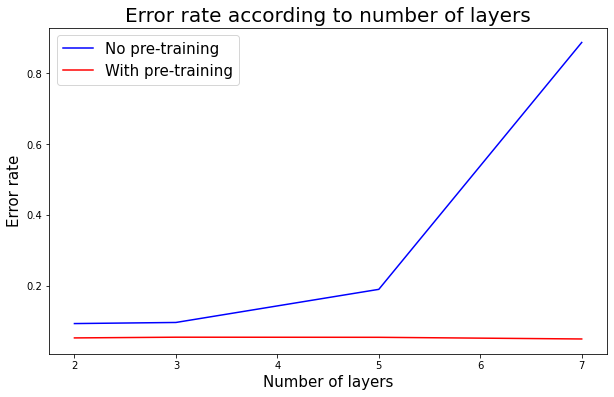

In [0]:
plt.plot(n_layers_l, error_rates_1, label='No pre-training', color='blue')
plt.plot(n_layers_l, error_rates_2, label='With pre-training', color='red')
plt.title('Error rate according to number of layers', size=20)
plt.xlabel('Number of layers', size=15)
plt.ylabel('Error rate', size=15)
plt.legend(fontsize=15)

fig = plt.gcf()
fig.set_size_inches(10,6)
fig.savefig('n_layers.jpg', dpi = 300, bbox_inches='tight', orientation = 'landscape')

### 2 Réseaux en fonction du nombre de neuronnes par couches

In [0]:
# Parameters
n_samples = 60000
q_l = [100, 300, 500, 700, 1000]
n_layers = 2

error_rates_1, error_rates_2 = [], []

for q in q_l:
    # Initialization
    DNN_trained = init_DBN(p, q, n_layers)
    DNN_pre_trained = copy.deepcopy(DNN_trained)
    
    # Training
    DNN_trained = principal_mnist(n_samples, DNN_trained, pre_train=False, nb_iter=nb_iter, nb_iter_RBM=nb_iter_RBM, lr=lr, batch_size=batch_size, verbose=verbose)
    DNN_pre_trained = principal_mnist(n_samples, DNN_pre_trained, pre_train=True, nb_iter=nb_iter, nb_iter_RBM=nb_iter_RBM, lr=lr, batch_size=batch_size, verbose=verbose)

    error_rates_1.append(test_DNN(DNN_trained, test_image, test_label))
    error_rates_2.append(test_DNN(DNN_pre_trained, test_image, test_label))

iteration 0 	 : 	 loss 0.23161 - accuracy 0.10596
iteration 1 	 : 	 loss 0.23081 - accuracy 0.11084
iteration 2 	 : 	 loss 0.23040 - accuracy 0.12012
iteration 3 	 : 	 loss 0.22994 - accuracy 0.12646
iteration 4 	 : 	 loss 0.22941 - accuracy 0.13452
iteration 5 	 : 	 loss 0.22875 - accuracy 0.14648
iteration 6 	 : 	 loss 0.22791 - accuracy 0.16138
iteration 7 	 : 	 loss 0.22678 - accuracy 0.18042
iteration 8 	 : 	 loss 0.22518 - accuracy 0.20801
iteration 9 	 : 	 loss 0.22278 - accuracy 0.24634
iteration 10 	 : 	 loss 0.21898 - accuracy 0.27979
iteration 11 	 : 	 loss 0.21278 - accuracy 0.31763
iteration 12 	 : 	 loss 0.20321 - accuracy 0.34839
iteration 13 	 : 	 loss 0.19081 - accuracy 0.39551
iteration 14 	 : 	 loss 0.17741 - accuracy 0.44312
iteration 15 	 : 	 loss 0.16364 - accuracy 0.49146
iteration 16 	 : 	 loss 0.14927 - accuracy 0.53760
iteration 17 	 : 	 loss 0.13529 - accuracy 0.57495
iteration 18 	 : 	 loss 0.12331 - accuracy 0.60498
iteration 19 	 : 	 loss 0.11370 - accurac

In [0]:
print(error_rates_1)
print(error_rates_2)

[0.09509999999999996, 0.09130000000000005, 0.0988, 0.10019999999999996, 0.0968]
[0.07040000000000002, 0.05700000000000005, 0.050000000000000044, 0.04579999999999995, 0.04849999999999999]


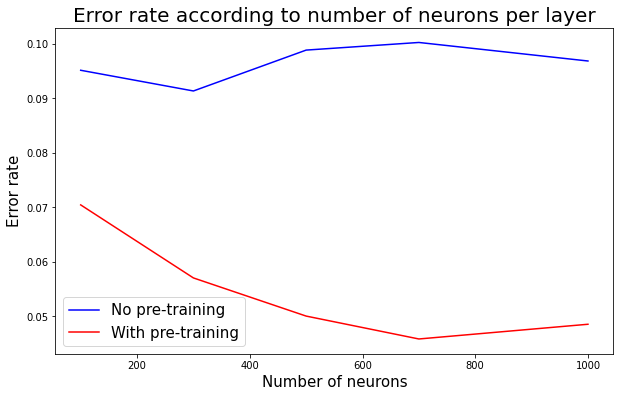

In [0]:
plt.plot(q_l, error_rates_1, label='No pre-training', color='blue')
plt.plot(q_l, error_rates_2, label='With pre-training', color='red')
plt.title('Error rate according to number of neurons per layer', size=20)
plt.xlabel('Number of neurons', size=15)
plt.ylabel('Error rate', size=15)
plt.legend(fontsize=15)

fig = plt.gcf()
fig.set_size_inches(10,6)
fig.savefig('n_neurons.jpg', dpi = 300, bbox_inches='tight', orientation = 'landscape')

### 3 Réseaux en fonction du nombre de données train

In [0]:
# Parameters
n_samples_l = [1000, 3000, 7000, 10000, 30000, 60000]
q = 200
n_layers = 2

error_rates_1, error_rates_2 = [], []

for n_samples in n_samples_l:
    # Initialization
    DNN_trained = init_DBN(p, q, n_layers)
    DNN_pre_trained = copy.deepcopy(DNN_trained)
    
    # Training
    DNN_trained = principal_mnist(n_samples, DNN_trained, pre_train=False, nb_iter=nb_iter, nb_iter_RBM=nb_iter_RBM, lr=lr, batch_size=batch_size, verbose=verbose)
    DNN_pre_trained = principal_mnist(n_samples, DNN_pre_trained, pre_train=True, nb_iter=nb_iter, nb_iter_RBM=nb_iter_RBM, lr=lr, batch_size=batch_size, verbose=verbose)

    error_rates_1.append(test_DNN(DNN_trained, test_image, test_label))
    error_rates_2.append(test_DNN(DNN_pre_trained, test_image, test_label))

iteration 0 	 : 	 loss 0.06043 - accuracy 0.77979
iteration 1 	 : 	 loss 0.06793 - accuracy 0.77905
iteration 2 	 : 	 loss 0.06777 - accuracy 0.78198
iteration 3 	 : 	 loss 0.06761 - accuracy 0.78540
iteration 4 	 : 	 loss 0.06741 - accuracy 0.79028
iteration 5 	 : 	 loss 0.06716 - accuracy 0.79590
iteration 6 	 : 	 loss 0.06682 - accuracy 0.80127
iteration 7 	 : 	 loss 0.06635 - accuracy 0.80273
iteration 8 	 : 	 loss 0.06570 - accuracy 0.80542
iteration 9 	 : 	 loss 0.06480 - accuracy 0.81396
iteration 10 	 : 	 loss 0.06359 - accuracy 0.81836
iteration 11 	 : 	 loss 0.06203 - accuracy 0.82520
iteration 12 	 : 	 loss 0.06010 - accuracy 0.83008
iteration 13 	 : 	 loss 0.05791 - accuracy 0.83618
iteration 14 	 : 	 loss 0.05557 - accuracy 0.84131
iteration 15 	 : 	 loss 0.05323 - accuracy 0.84668
iteration 16 	 : 	 loss 0.05108 - accuracy 0.84985
iteration 17 	 : 	 loss 0.04928 - accuracy 0.85449
iteration 18 	 : 	 loss 0.04785 - accuracy 0.85913
iteration 19 	 : 	 loss 0.04665 - accurac

In [0]:
print(error_rates_1)
print(error_rates_2)

[0.14670000000000005, 0.10660000000000003, 0.0917, 0.08899999999999997, 0.0927, 0.09099999999999997]
[0.10319999999999996, 0.06940000000000002, 0.06120000000000003, 0.05710000000000004, 0.05630000000000002, 0.05259999999999998]


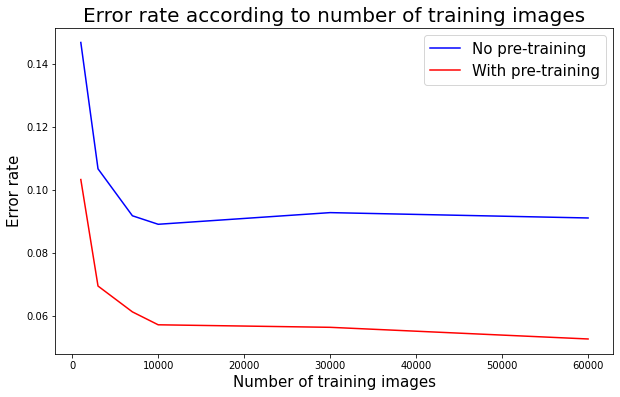

In [0]:
plt.plot(n_samples_l, error_rates_1, label='No pre-training', color='blue')
plt.plot(n_samples_l, error_rates_2, label='With pre-training', color='red')
plt.title('Error rate according to number of training images', size=20)
plt.xlabel('Number of training images', size=15)
plt.ylabel('Error rate', size=15)
plt.legend(fontsize=15)

fig = plt.gcf()
fig.set_size_inches(10,6)
fig.savefig('n_samples.jpg', dpi = 300, bbox_inches='tight', orientation = 'landscape')